In [ ]:
import re
import pandas as pd
import numpy as np

In [ ]:
# ------------------ PARSING FUNCTION ------------------ #
def clean_procname(raw):
    """Clean trailing symbols from procname like [ or quotes"""
    return re.sub(r'[\[\]"]+', '', raw)

def parse_log_line(line):
    # Primary pattern to extract timestamp, time_elapsed, host, event_name
    head_pattern = re.compile(
        r"\[(?P<timestamp>[\d:.]+)\] "
        r"\(\+(?P<time_elapsed>[\d.]+)\) "
        r"(?P<host_name>\w+) "
        r"(?P<event_name>[\w_]+):"
    )

    match = head_pattern.match(line)
    if not match:
        return None
    gd = match.groupdict()

    # Extract the rest after matched header
    rest = line[match.end():].strip()

    # Extract cpu_id from first group
    cpu_match = re.search(r"\{ cpu_id = (?P<cpu_id>\d+) \}", rest)
    cpu_id = int(cpu_match.group("cpu_id")) if cpu_match else None

    # Extract procname, pid, tid
    proc_match = re.search(r'\{ procname = "(?P<procname>[^"]+)", pid = (?P<pid>\d+), tid = (?P<tid>\d+)', rest)
    if proc_match:
        procname = clean_procname(proc_match.group("procname"))
        process_details = f'pid = {proc_match.group("pid")}, tid = {proc_match.group("tid")}'
    else:
        procname = None
        process_details = None

    # Extract kernel_details: use the last curly-braced group
    kernel_groups = re.findall(r"\{ ([^{}]+) \}", rest)
    kernel_details = kernel_groups[-1] if kernel_groups else None

    return {
        "timestamp": gd["timestamp"],
        "time_elapsed": gd["time_elapsed"],
        "host_name": gd["host_name"],
        "event_name": gd["event_name"],
        "cpu_id": cpu_id,
        "procname": procname,
        "process_details": process_details,
        "kernel_details": kernel_details
    }

def parse_log_file(file_path):
    parsed_rows = []
    with open(file_path) as f:
        for line in f:
            row = parse_log_line(line)
            if row:
                parsed_rows.append(row)
    return pd.DataFrame(parsed_rows)

# ------------------ DATA LOADING ------------------ #
real_df = parse_log_file("kernel_trace_100K.txt")

In [ ]:
real_df['unique_id'] = range(1, len(real_df) + 1)

In [ ]:
real_df

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,process_details,kernel_details,unique_id
0,06:13:02.227912438,0.000003750,mendax,syscall_exit_accept,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 576, upeer_sockaddr = 246916502706648, u...",1
1,06:13:02.227914646,0.000002208,mendax,syscall_entry_fcntl,2,elasticsearchm,"pid = 11822, tid = 11859","fd = 576, cmd = 3, arg = 50",2
2,06:13:02.227914980,0.000000334,mendax,syscall_exit_fcntl,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 2, arg = 50",3
3,06:13:02.227916313,0.000001333,mendax,syscall_entry_getsockname,2,elasticsearchm,"pid = 11822, tid = 11859","fd = 576, usockaddr_len = 246916502706368",4
4,06:13:02.227916771,0.000000458,mendax,syscall_exit_getsockname,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 0, usockaddr = 246916502706376, usockadd...",5
...,...,...,...,...,...,...,...,...,...
99994,06:13:09.322503258,0.000001334,mendax,syscall_exit_epoll_pwait,1,Mutter Input Th,"pid = 3154, tid = 3269","EPOLLIN = 1, EPOLLPRI = 0, EPOLLOUT = 0, EPOLL...",99995
99995,06:13:09.322504341,0.000001083,mendax,syscall_entry_read,1,Mutter Input Th,"pid = 3154, tid = 3269","fd = 27, count = 6144",99996
99996,06:13:09.322506008,0.000001667,mendax,syscall_exit_read,1,Mutter Input Th,"pid = 3154, tid = 3269","ret = 72, buf = 248271726143264",99997
99997,06:13:09.322507716,0.000001708,mendax,syscall_entry_read,1,Mutter Input Th,"pid = 3154, tid = 3269","fd = 27, count = 6144",99998


In [ ]:
high_card_cols = [
    "timestamp", "time_elapsed", "host_name",
    "event_name", "procname", "process_details", "kernel_details"
]

In [ ]:
!pip install sdv

In [ ]:
import sdv

In [ ]:
from sdv.single_table import CTGANSynthesizer

In [ ]:
from rdt import HyperTransformer
from rdt.transformers.categorical import LabelEncoder

ht = HyperTransformer()
ht.detect_initial_config(real_df)

# Step 2: Update transformers for high-cardinality columns
ht.update_transformers({
    col: LabelEncoder(add_noise=True) for col in high_card_cols
})

use_df = ht.fit_transform(real_df)

In [ ]:
use_df

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,process_details,kernel_details,unique_id
0,0.585887,0.321918,0.558958,0.539084,2.0,0.639100,0.153453,0.194634,1.0
1,1.658380,1.820227,0.232840,1.702105,2.0,0.752111,0.395442,1.433382,2.0
2,2.656928,2.360622,0.171446,2.552724,2.0,0.163921,0.678600,2.921404,3.0
3,3.851122,3.923801,0.000875,3.563575,2.0,0.918544,0.060984,3.621939,4.0
4,4.356116,4.455945,0.793501,4.286756,2.0,0.644360,0.639527,4.529014,5.0
...,...,...,...,...,...,...,...,...,...
99994,96296.200244,98.505769,0.808148,31.649758,1.0,29.322895,58.966970,93.094317,99995.0
99995,96297.085710,94.273149,0.143157,32.776098,1.0,29.730918,58.058884,7292.534512,99996.0
99996,96298.414365,215.205680,0.028377,33.316238,1.0,29.269834,58.793283,7293.450038,99997.0
99997,96299.261628,292.816845,0.653230,32.682883,1.0,29.365000,58.064477,7292.683276,99998.0


In [ ]:
from sdv.metadata import Metadata
from sdv.metadata import SingleTableMetadata
from rdt.transformers import UniformEncoder

# meta data generation
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(use_df)
metadata.primary_key = "unique_id"

# Set columns that were label-encoded as numerical
for col in high_card_cols:
    metadata.update_column(column_name=col, sdtype="numerical")

In [ ]:
metadata.columns

{'timestamp': {'sdtype': 'numerical'},
 'time_elapsed': {'sdtype': 'numerical'},
 'host_name': {'sdtype': 'numerical'},
 'event_name': {'sdtype': 'numerical'},
 'cpu_id': {'sdtype': 'id'},
 'procname': {'sdtype': 'numerical'},
 'process_details': {'sdtype': 'numerical'},
 'kernel_details': {'sdtype': 'numerical'},
 'unique_id': {'sdtype': 'id'}}

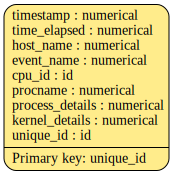

In [ ]:
metadata.visualize()

In [ ]:
# synthesizing data / Training on sample data using CTGAN
synthesizer = CTGANSynthesizer(metadata, epochs=300)
synthesizer.fit(use_df)

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:162: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:128: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [ ]:
synthetic_df = synthesizer.sample(100000)
synthetic_data = ht.reverse_transform(synthetic_df)

In [ ]:
synthetic_data

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,process_details,kernel_details,unique_id
0,06:13:08.870205661,0.000003208,mendax,syscall_entry_openat,1,gnome-terminal-,"pid = 3154, tid = 3209","dfd = -100, filename = ""/var/lib/snapd/desktop...",7802353
1,06:13:05.332948263,0.000125746,mendax,syscall_exit_getsockopt,2,Isolated Web Co,"pid = 13361, tid = 13361",brk = 203053665472512,13580013
2,06:13:09.305956592,0.000045749,mendax,syscall_entry_recvmsg,1,KMS thread,"pid = 3154, tid = 3209","dfd = -100, filename = ""."", flag = 0",1285479
3,06:13:08.773929151,0.000000125,mendax,syscall_entry_getpid,2,llvmpipe-0,"pid = 3154, tid = 3213","uaddr = 194557001609584, op = 129, val = 1, ut...",1424580
4,06:13:08.283353856,0.000002583,mendax,syscall_exit_sendto,1,llvmpipe-1,"pid = 3154, tid = 3209","fd = 67, count = 8",15206039
...,...,...,...,...,...,...,...,...,...
99995,06:13:07.572359749,0.000023791,mendax,syscall_entry_recvmsg,0,curl,"pid = 3154, tid = 3154",ret = 187868841869312,4729267
99996,06:13:08.293768610,0.000001041,mendax,syscall_entry_futex,2,llvmpipe-3,"pid = 3154, tid = 3216","ret = 32, buf = 246916493257208",12889515
99997,06:13:08.788335128,0.000000125,mendax,syscall_exit_futex,3,gnome-shell,"pid = 11822, tid = 11867","epfd = 548, maxevents = 1024, timeout = 10000,...",4629184
99998,06:13:08.229843791,0.000014708,mendax,syscall_exit_setsockopt,3,KMS thread,"pid = 14341, tid = 14341","epfd = 546, maxevents = 1024, timeout = 10000,...",5671656


In [ ]:
synthetic_data["timestamp"] = synthetic_data["timestamp"].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2}\.\d+)')[0]

In [ ]:
real_df

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,process_details,kernel_details,unique_id
0,06:13:02.227912438,0.000003750,mendax,syscall_exit_accept,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 576, upeer_sockaddr = 246916502706648, u...",1
1,06:13:02.227914646,0.000002208,mendax,syscall_entry_fcntl,2,elasticsearchm,"pid = 11822, tid = 11859","fd = 576, cmd = 3, arg = 50",2
2,06:13:02.227914980,0.000000334,mendax,syscall_exit_fcntl,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 2, arg = 50",3
3,06:13:02.227916313,0.000001333,mendax,syscall_entry_getsockname,2,elasticsearchm,"pid = 11822, tid = 11859","fd = 576, usockaddr_len = 246916502706368",4
4,06:13:02.227916771,0.000000458,mendax,syscall_exit_getsockname,2,elasticsearchm,"pid = 11822, tid = 11859","ret = 0, usockaddr = 246916502706376, usockadd...",5
...,...,...,...,...,...,...,...,...,...
99994,06:13:09.322503258,0.000001334,mendax,syscall_exit_epoll_pwait,1,Mutter Input Th,"pid = 3154, tid = 3269","EPOLLIN = 1, EPOLLPRI = 0, EPOLLOUT = 0, EPOLL...",99995
99995,06:13:09.322504341,0.000001083,mendax,syscall_entry_read,1,Mutter Input Th,"pid = 3154, tid = 3269","fd = 27, count = 6144",99996
99996,06:13:09.322506008,0.000001667,mendax,syscall_exit_read,1,Mutter Input Th,"pid = 3154, tid = 3269","ret = 72, buf = 248271726143264",99997
99997,06:13:09.322507716,0.000001708,mendax,syscall_entry_read,1,Mutter Input Th,"pid = 3154, tid = 3269","fd = 27, count = 6144",99998


In [ ]:
synthetic_data["host_name"] = synthetic_data["host_name"].replace("mendax", "synthetic_host")

In [ ]:
synthetic_data

,timestamp,time_elapsed,host_name,event_name,cpu_id,procname,process_details,kernel_details,unique_id
0,06:13:08.870205661,0.000003208,synthetic_host,syscall_entry_openat,1,gnome-terminal-,"pid = 3154, tid = 3209","dfd = -100, filename = ""/var/lib/snapd/desktop...",7802353
1,06:13:05.332948263,0.000125746,synthetic_host,syscall_exit_getsockopt,2,Isolated Web Co,"pid = 13361, tid = 13361",brk = 203053665472512,13580013
2,06:13:09.305956592,0.000045749,synthetic_host,syscall_entry_recvmsg,1,KMS thread,"pid = 3154, tid = 3209","dfd = -100, filename = ""."", flag = 0",1285479
3,06:13:08.773929151,0.000000125,synthetic_host,syscall_entry_getpid,2,llvmpipe-0,"pid = 3154, tid = 3213","uaddr = 194557001609584, op = 129, val = 1, ut...",1424580
4,06:13:08.283353856,0.000002583,synthetic_host,syscall_exit_sendto,1,llvmpipe-1,"pid = 3154, tid = 3209","fd = 67, count = 8",15206039
...,...,...,...,...,...,...,...,...,...
99995,06:13:07.572359749,0.000023791,synthetic_host,syscall_entry_recvmsg,0,curl,"pid = 3154, tid = 3154",ret = 187868841869312,4729267
99996,06:13:08.293768610,0.000001041,synthetic_host,syscall_entry_futex,2,llvmpipe-3,"pid = 3154, tid = 3216","ret = 32, buf = 246916493257208",12889515
99997,06:13:08.788335128,0.000000125,synthetic_host,syscall_exit_futex,3,gnome-shell,"pid = 11822, tid = 11867","epfd = 548, maxevents = 1024, timeout = 10000,...",4629184
99998,06:13:08.229843791,0.000014708,synthetic_host,syscall_exit_setsockopt,3,KMS thread,"pid = 14341, tid = 14341","epfd = 546, maxevents = 1024, timeout = 10000,...",5671656


In [ ]:
synthetic_data['timestamp'] = "'" + synthetic_data['timestamp'].astype(str)
synthetic_data.to_csv("synthetic_linux_logs_100K_CTGAN.csv", index=False)